In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tikzplotlib
import os

import scipy.stats as st

In [5]:
scratchHPC = r'O:\scratch\MultiPhase'

In [6]:
StudienOrdner = '211130_HRC37_MaxMart'
StudienOrdner = os.path.join(scratchHPC, StudienOrdner)


ImageOrdner = os.path.join(StudienOrdner, '_image' )

if not os.path.exists(ImageOrdner):
    os.makedirs(ImageOrdner)

In [7]:
lf_csv = r'lifetime.csv'
lf_csv = os.path.join(StudienOrdner, lf_csv)

In [8]:
df_lf = pd.read_csv(lf_csv)

FileNotFoundError: [Errno 2] No such file or directory: 'O:\\scratch\\MultiPhase\\211130_HRC37_MaxMart\\lifetime.csv'

In [9]:
df_lf

NameError: name 'df_lf' is not defined

In [7]:
ll_volf = df_lf['ModelName'].tolist()
ll_volf = [float(kk[kk.rfind('_')+15:])   for kk in ll_volf]

ll_Seed = df_lf['ModelName'].tolist()
ll_Seed = [str(kk[kk.find('_')+5:kk.find('Strain')-1])   for kk in ll_Seed]

In [8]:
minimia_vol = min(ll_volf)
maxima_vol = max(ll_volf)

In [9]:
df_lf['Volume_Martensite'] = ll_volf
df_lf['Seed'] = ll_Seed

df_wholMod = df_lf[df_lf['Phase']=='wholeMod']

In [10]:
norm = matplotlib.colors.Normalize(vmin=minimia_vol, vmax=maxima_vol, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm) 

In [11]:
from scipy import optimize

def tfunktion(x_data, a,b):
    return a*(x_data**2)+b*x_data+x_data


In [12]:
params, params_covariance = optimize.curve_fit(tfunktion, df_wholMod['Lifetime'].tolist(), df_wholMod['StrainAmplitude'].tolist(),)

In [13]:
colorswhole = df_wholMod['Volume_Martensite'].tolist()
un_voll = np.unique(colorswhole)
colorswhole = [float(c) for c in colorswhole]

strain_ll = np.unique(df_wholMod['StrainAmplitude'].tolist())

dic_f_curve = {}
for  vol in un_voll:
    df_red = df_wholMod[df_wholMod['Volume_Martensite']==vol]
    params, params_covariance = optimize.curve_fit(tfunktion, df_red['Lifetime'].tolist(), df_red['StrainAmplitude'].tolist())
    
    ll_mean_lifetimes = [np.min(df_red[df_red['StrainAmplitude']==stra]['Lifetime'].tolist()) for stra in strain_ll]
    print(ll_mean_lifetimes)
    f_curve = [tfunktion(lf, params[0], params[1]) for lf in ll_mean_lifetimes]
    dic_f_curve[vol] = f_curve

print(dic_f_curve)

ValueError: zero-size array to reduction operation minimum which has no identity

Text(0, 0.5, 'Strain')

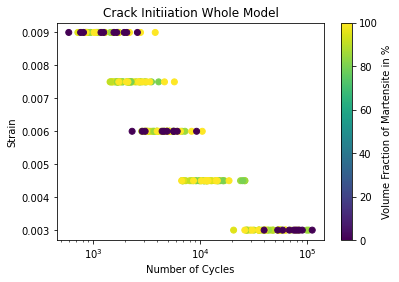

In [14]:

plt.scatter(df_wholMod['Lifetime'], df_wholMod['StrainAmplitude'], c=colorswhole)
cbar = plt.colorbar(mapper)
cbar.set_label('Volume Fraction of Martensite in %')
plt.xscale('log')
plt.title('Crack Initiiation Whole Model')
plt.xlabel('Number of Cycles')
plt.ylabel('Strain')
#plt.show()


#plt.savefig(os.path.join(StudienOrdner, 'ScatterLifetimeWholeMod.png'), bbox_inches='tight', dpi=150, transparent=True)

In [15]:
df_Ferrite = df_lf[df_lf['Phase']=='Ferrite']

In [16]:
colorsFerr = df_Ferrite['Volume_Martensite'].tolist()
colorsFerr = [float(c) for c in colorsFerr]

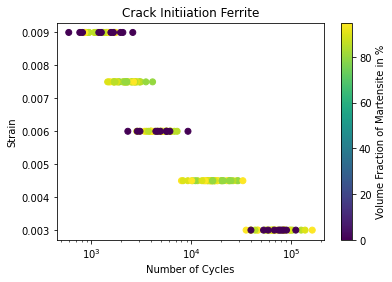

In [17]:
plt.scatter(df_Ferrite['Lifetime'], df_Ferrite['StrainAmplitude'], c=colorsFerr)
cbar = plt.colorbar()
cbar.set_label('Volume Fraction of Martensite in %')
plt.xscale('log')
plt.title('Crack Initiiation Ferrite')
plt.xlabel('Number of Cycles')
plt.ylabel('Strain')
plt.show()

In [18]:
df_mart = df_lf[df_lf['Phase']=='Martensite']

In [19]:
colorsMart = df_mart['Volume_Martensite'].tolist()
colorsMart = [int(c) for c in colorsMart]

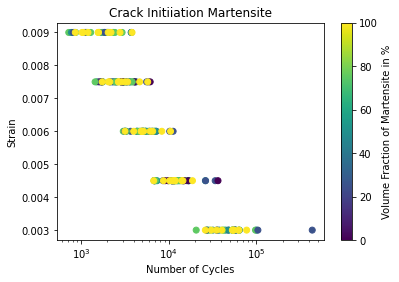

In [20]:
plt.scatter(df_mart['Lifetime'], df_mart['StrainAmplitude'], c=colorsMart)
cbar = plt.colorbar(mapper)
cbar.set_label('Volume Fraction of Martensite in %')
plt.xscale('log')
plt.title('Crack Initiiation Martensite')
plt.xlabel('Number of Cycles')
plt.ylabel('Strain')
plt.show()

Abwärts erstelle confidence intervalle

In [21]:
strainll = np.unique(df_wholMod['StrainAmplitude'].tolist())
dic_df_conf = {}
ch_df = {'whole': df_wholMod, 'Ferrite': df_Ferrite, 'Martensite': df_mart}
dd_ll = ['whole','Ferrite','Martensite']
for dd in dd_ll:
    df_conf = pd.DataFrame({'StrainAmplitude': strainll})
    for vols in np.unique(ll_volf):
        mean = []
        l_bound= []
        u_bound =  []
        for strain in strainll:
            rdf = ch_df[dd][ch_df[dd]['Volume_Martensite'] == vols]
            rdf = rdf[rdf['StrainAmplitude'] == strain]
            a = rdf['Lifetime'].tolist()
            if len(a) != 0:
                s_mean = np.mean(a)
                sl_bound, su_bound = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
                if sl_bound<0:
                    sl_bound = min(a)
            if len(a) == 0:
                s_mean,sl_bound, su_bound = np.NaN,np.NaN,np.NaN

            mean.append(s_mean), l_bound.append(sl_bound), u_bound.append(su_bound)
        df_conf['l_bound VolF '+ str(vols)] = l_bound
        df_conf['mean VolF '+ str(vols)] = mean
        df_conf['u_bound VolF '+ str(vols)] = u_bound
    dic_df_conf[dd] = df_conf

Plotten der confidence Intervalle

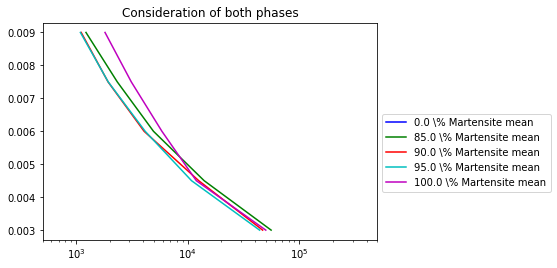

In [22]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']
df_conf = dic_df_conf['whole']
ll_volf = [kk  for kk in ll_volf if kk not in [75.0, 80.0]]
for num, vols in enumerate(np.unique(ll_volf)):

    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StrainAmplitude'], label= (str(vols)+' \% Martensite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
plt.xscale('log')
plt.title('Consideration of both phases')
plt.legend(loc= 'lower left',bbox_to_anchor=(1.0, 0.2))#, ncol=2 )
plt.xlim([5*10**2,5*10**5])

tikzplotlib.save(os.path.join(ImageOrdner, 'ConfLifetimeWholeMod.tex'))
plt.savefig(os.path.join(ImageOrdner, 'ConfLifetimeWholeMod.png'), bbox_inches='tight', dpi=150, transparent=True)

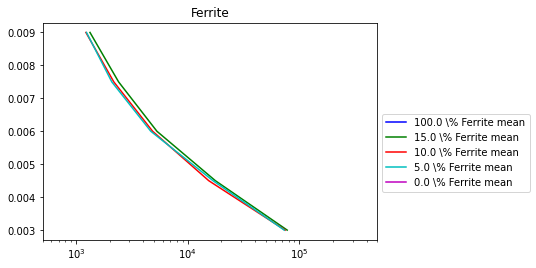

In [23]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']
df_conf = dic_df_conf['Ferrite']
volls_red = []
for num, vols in enumerate(np.unique(ll_volf)):
    #if num%2 == 0:
        volls_red.append(vols)
    
for num, vols in enumerate(volls_red):
    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StrainAmplitude'], label= (str(100-vols)+' \% Ferrite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
plt.xscale('log')
plt.title('Ferrite')
plt.legend(loc= 'lower left',bbox_to_anchor=(1.0, 0.2))#, ncol=2 )
plt.xlim([5*10**2,5*10**5])

tikzplotlib.save(os.path.join(ImageOrdner, 'ConfLifetimeFerrite.tex'))
plt.savefig(os.path.join(ImageOrdner, 'ConfLifetimeFerrite.png'), bbox_inches='tight', dpi=150, transparent=True)


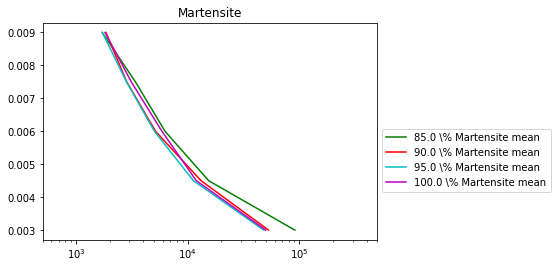

In [24]:
colorlist = ['g', 'r', 'c', 'm', 'y']
df_conf = dic_df_conf['Martensite']
volls_red = []
for num, vols in enumerate(np.unique(ll_volf)):
    if num%2 == 0:
        volls_red.append(vols)
volls_red = [85.0,90.0,95.0,100.0]
for num, vols in enumerate(volls_red):
    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StrainAmplitude'], label= (str(vols)+' \% Martensite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
plt.xscale('log')
plt.xlim([5*10**2,5*10**5])
plt.legend(loc = 'lower left',bbox_to_anchor=(1.0, 0.2))#, ncol=2 )
plt.title('Martensite')


tikzplotlib.save(os.path.join(ImageOrdner, 'ConfLifetimeMartensite.tex'))
plt.savefig(os.path.join(ImageOrdner, 'ConfLifetimeMartensite.png'), bbox_inches='tight', dpi=150, transparent=True)


In [25]:
### AChtung lower bound ist nicht ganz korrekt das dieser durch die große varianz eine negative Lebensdauer angeben würde
### dacher ist in diesen Fällen der Lower Bound = minimum der Lebenszeit für definierte Dehnung und Volumengehalt

In [26]:
mnbv= df_lf[df_lf['StrainAmplitude']==0.009]
mnbv= mnbv[mnbv['Seed']=='93426']
mnbv[mnbv['Volume_Martensite'].isin([95.0,75.0])]

,Unnamed: 0,ModelName,ModelGroup,Lifetime,Phase,_LoadingMode,StrainAmplitude,StrainMean,StressAmplitude,StressMean,FIPmax,FIPmaxLocal,FIPcrit,m_FIP,IsExperimentalData,Volume_Martensite,Seed
15,5.0,DisTest_Seed93426_Strain0p9_VolumeFraction95,ALL,895.036824,wholeMod,0.0,0.009,0.0,987.54,-1.249,0.048927,0.107422,2.521240,1.724138,0,95.0,93426
16,5.1,DisTest_Seed93426_Strain0p9_VolumeFraction95,ALL,1605.100320,Martensite,0.0,0.009,0.0,987.54,-1.249,0.025863,0.081032,1.870093,1.724138,0,95.0,93426
17,5.2,DisTest_Seed93426_Strain0p9_VolumeFraction95,ALL,895.036824,Ferrite,0.0,0.009,0.0,987.54,-1.249,0.048927,0.107422,2.521240,1.724138,0,95.0,93426


Bestimme liegt geringste Lebenszeit immer mit Ferrit zusammen? 

In [27]:
df_03 = df_lf[df_lf['StrainAmplitude']==0.003]
df_06 = df_lf[df_lf['StrainAmplitude']==0.006]
df_09 = df_lf[df_lf['StrainAmplitude']==0.009]

In [28]:
c_df = df_09 
ll_model = c_df['Unnamed: 0'].tolist()


ll_prob_phase = []
for mod in ll_model:
    if mod%1 == 0:
        ltime = c_df[c_df['Unnamed: 0'] == mod]['Lifetime']
        
        phases = [g for g in ll_model if int(mod) == int(g) and g!=mod]
        
        for ph in phases:
            if float(c_df[c_df['Unnamed: 0'] == ph]['Lifetime']) == float(ltime):
                ll_prob_phase.append([len(phases),df_lf[df_lf['Unnamed: 0'] == ph]['Phase'].values[0]])        

print(np.unique(ll_prob_phase,axis=0))

TypeError: cannot convert the series to <class 'float'>

In [29]:
ll_prob_phase = []
for mod in ll_model:
    if mod%1 == 0:
        ltime = df_lf[df_lf['Unnamed: 0'] == mod]['Lifetime']
        
        phases = [g for g in ll_model if int(mod) == int(g) and g!=mod]
        ltime = 9e300
        phaseprob = ''
        for ph in phases:
            if float(df_lf[df_lf['Unnamed: 0'] == ph]['Lifetime']) < ltime:
                ltime = float(df_lf[df_lf['Unnamed: 0'] == ph]['Lifetime'])
                phaseprob = df_lf[df_lf['Unnamed: 0'] == ph]['Phase'].values[0]
        ll_prob_phase.append([len(phases),phaseprob])        

print(np.unique(ll_prob_phase,axis=0))

TypeError: cannot convert the series to <class 'float'>

In [30]:
strainll = np.unique(df_wholMod['StrainAmplitude'].tolist())
dic_df_StressAmp = {}
ch_df = {'whole': df_wholMod, 'Ferrite': df_Ferrite, 'Martensite': df_mart}
dd_ll = ['whole','Ferrite','Martensite']
for dd in dd_ll:
    df_conf = pd.DataFrame({'StrainAmplitude': strainll})
    for vols in np.unique(ll_volf):
        mean = []
        l_bound= []
        u_bound =  []
        for strain in strainll:
            rdf = ch_df[dd][ch_df[dd]['Volume_Martensite'] == vols]
            rdf = rdf[rdf['StrainAmplitude'] == strain]
            a = rdf['StressAmplitude'].tolist()
            if len(a) != 0:
                s_mean = np.mean(a)
                sl_bound, su_bound = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
                if sl_bound<0:
                    sl_bound = min(a)
            if len(a) == 0:
                s_mean,sl_bound, su_bound = np.NaN,np.NaN,np.NaN

            mean.append(s_mean), l_bound.append(sl_bound), u_bound.append(su_bound)
        df_conf['l_bound VolF '+ str(vols)] = l_bound
        df_conf['mean VolF '+ str(vols)] = mean
        df_conf['u_bound VolF '+ str(vols)] = u_bound
    dic_df_StressAmp[dd] = df_conf

Plotten confidence Intervalle bezogen auf Stress::

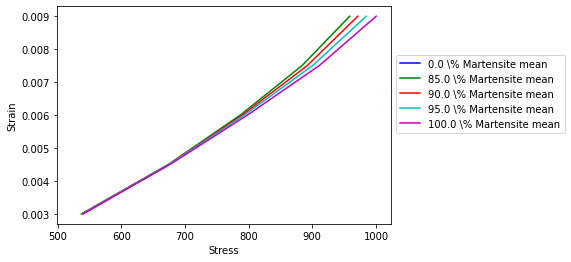

In [31]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']

df_conf = dic_df_StressAmp['whole']
for num, vols in enumerate(np.unique(ll_volf)):
    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StrainAmplitude'], label= (str(vols)+' \% Martensite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
#plt.xscale('log')
plt.legend(bbox_to_anchor=(1.0, 0.8), ncol=1 )
plt.xlabel('Stress')
plt.ylabel('Strain')
plt.title('')


tikzplotlib.save(os.path.join(ImageOrdner, 'StressAmplitude.tex'))
plt.savefig(os.path.join(ImageOrdner, 'StressAmplitude.png'), bbox_inches='tight', dpi=150, transparent=True)


In [138]:
df_conf

,StrainAmplitude,l_bound VolF 0.0,mean VolF 0.0,u_bound VolF 0.0,l_bound VolF 85.0,mean VolF 85.0,u_bound VolF 85.0,l_bound VolF 90.0,mean VolF 90.0,u_bound VolF 90.0,l_bound VolF 95.0,mean VolF 95.0,u_bound VolF 95.0,l_bound VolF 100.0,mean VolF 100.0,u_bound VolF 100.0
0,0.003,521.687243,522.23840,522.789557,536.852784,537.50120,538.149616,537.454280,538.18685,538.919420,538.005603,538.8505,539.695397,539.565143,540.21290,540.860657
1,0.006,723.583532,725.30785,727.032168,785.944977,786.94065,787.936323,788.911859,790.04330,791.174741,791.893438,793.2877,794.681962,797.352152,798.13110,798.910048
2,0.009,767.629556,769.65780,771.686044,956.812550,958.72575,960.638950,969.586843,971.51010,973.433357,982.579493,984.7113,986.843107,998.885386,1000.34055,1001.795714


BoxPlots:-->

WholeMod

In [238]:
max_life = max(df_lf['Lifetime'].tolist())
min_life = min(df_lf['Lifetime'].tolist())

In [324]:
red_vols = [100.0, 80.0, 90.0, 0.0]
red_vols = np.unique(red_vols)
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']

In [325]:
dic_df_whole_strains = {}
un_whole_strains = np.unique(df_wholMod['StrainAmplitude'].tolist())
for strains in un_whole_strains:
    whole_vols = df_wholMod[df_wholMod['StrainAmplitude']==strains]
    red_vols_df = whole_vols[whole_vols['Volume_Martensite'].isin(red_vols)]
    dic_df_whole_strains[strains] = {'wholestrain': red_vols_df}

In [326]:
volumes = []
for strains, dic in dic_df_whole_strains.items():
    un_whole_vol = np.unique(df_wholMod['Volume_Martensite'].tolist())
    un_whole_vol = [kk for kk in un_whole_vol if kk in red_vols]
    df_bb = dic['wholestrain']
    for volumes in un_whole_vol:
           dic_df_whole_strains[strains][volumes] = df_bb[df_bb['Volume_Martensite']==volumes]
    dic_df_whole_strains[strains]['volumes'] = list(un_whole_vol)
    

In [327]:
for strains, dic in dic_df_whole_strains.items():
    ll_life = []
    dic_df_whole_strains[strains]['LL_lifetime'] = ""
    for key, di in dic.items():
        if key in dic['volumes']:
            ll_life.append(di['Lifetime'].tolist())
    dic_df_whole_strains[strains]['LL_lifetime'] = ll_life

del ll_life

In [328]:
def setBoxColors(bp, re_vols):
    #colorlist = ['b', 'g', 'r', 'c', 'm', 'y']
    for box in range(len(re_vols)):
        plt.setp(bp['boxes'][box], color=colorlist[box])
        plt.setp(bp['caps'][(box*2)+1], color=colorlist[box])
        
        plt.setp(bp['caps'][(box*2)], color=colorlist[box])
        plt.setp(bp['whiskers'][(box*2)+1], color=colorlist[box])
        plt.setp(bp['whiskers'][(box*2)], color=colorlist[box])
        #plt.setp(bp['fliers'][box], color=colorlist[box])
        plt.setp(bp['medians'][box], color=colorlist[box])

Strain 0.003 Boxplots

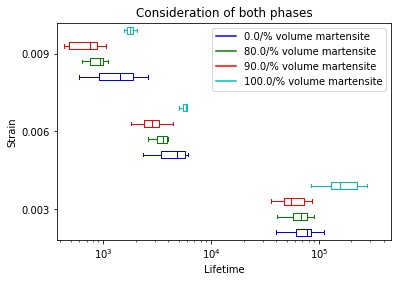

In [331]:
fig = plt.figure()
ax = plt.axes()
#plt.hold(True)
ticklist = []
positions = [kk+1 for kk in range(len(red_vols))]
min_lim = 1e200
max_lim = 0
for strain in un_whole_strains:
#strain = 0.003
    mx = max([max(kk) for kk in dic_df_whole_strains[strain]['LL_lifetime'] ])
    mn = min([min(kk) for kk in dic_df_whole_strains[strain]['LL_lifetime'] ])
    if mn<min_lim: min_lim = mn
    if mx>max_lim: max_lim = mx
         
    bp = plt.boxplot(dic_df_whole_strains[strain]['LL_lifetime'], positions=positions, vert=False, sym = "", labels= red_vols)
    setBoxColors(bp, red_vols)
    ticklist.append(np.mean(positions))
    positions = [kk+1+len(positions) for kk in positions]


#plt.yticks([num +1 for num in range(len(dic_df_whole_strains[strain]['volumes']))], dic_df_whole_strains[strain]['volumes'])

ylabel = [str(kk) for kk in un_whole_strains]
plt.yticks(ticklist, ylabel)
plt.xlabel('Lifetime')
plt.ylabel('Strain')
plt.title('Consideration of both phases')
#plt.legend([colorlist[kk] for kk in range(len(red_vols))],red_vols,loc = 'lower left',bbox_to_anchor=(1.0, 0.2))#, ncol=2 )legend((hB, hR),('Apples', 'Oranges'))
#plt.legend()
plt.xscale('log')
plt.xlim(min_lim*0.85, max_lim*1.1)
## custom legend
leg=[]
for num, kk in enumerate(red_vols):
    #leg = [plt.plot([1,1],colorlist[num]+'-')  for num, kk in enumerate(red_vols)]
    hh, = plt.plot([1,1],colorlist[num]+'-')
    #hh.set_visible(False)
    leg.append(hh)
plt.legend(leg, [str(kk)+ '/% volume martensite' for kk in red_vols])

tikzplotlib.save(os.path.join(ImageOrdner, 'Boxplot_Whole_whoeler.tex'))
plt.savefig(os.path.join(ImageOrdner, 'Boxplot_Whole_whoeler.png'), bbox_inches='tight', dpi=150, transparent=True)

In [189]:
df_wholMod[df_wholMod['Volume_Martensite'] == 100.0]

,Unnamed: 0,ModelName,ModelGroup,Lifetime,Phase,_LoadingMode,StrainAmplitude,StrainMean,StressAmplitude,StressMean,FIPmax,FIPmaxLocal,FIPcrit,m_FIP,IsExperimentalData,Volume_Martensite,Seed
36,12.0,DisTest_Seed25609_Strain0p9_VolumeFraction100,ALL,1582.940817,wholeMod,0.0,0.009,0.0,1662.6600,0.0000,0.007190,0.010937,0.515708,1.724138,0,100.0,25609
47,16.0,DisTest_Seed54667_Strain0p6_VolumeFraction100,ALL,9328.333886,wholeMod,0.0,0.006,0.0,1153.7700,0.0000,0.002570,0.007027,0.515708,1.724138,0,100.0,54667
55,19.0,DisTest_Seed25609_Strain0p6_VolumeFraction100,ALL,5896.393760,wholeMod,0.0,0.006,0.0,1155.7700,0.0000,0.003353,0.005956,0.515708,1.724138,0,100.0,25609
63,22.0,DisTest_Seed54667_Strain0p3_VolumeFraction100,ALL,426095.672227,wholeMod,0.0,0.003,0.0,625.0670,-0.0050,0.000280,0.001563,0.515708,1.724138,0,100.0,54667
71,25.0,DisTest_Seed93426_Strain0p6_VolumeFraction100,ALL,5749.503117,wholeMod,0.0,0.006,0.0,1154.6950,-0.0050,0.003403,0.005795,0.515708,1.724138,0,100.0,93426
94,33.0,DisTest_Seed45213_Strain0p6_VolumeFraction100,ALL,5880.405850,wholeMod,0.0,0.006,0.0,1157.3150,-0.0050,0.003359,0.006404,0.515708,1.724138,0,100.0,45213
141,49.0,DisTest_Seed36003_Strain0p3_VolumeFraction100,ALL,276105.921525,wholeMod,0.0,0.003,0.0,626.6880,-0.0050,0.000360,0.001445,0.515708,1.724138,0,100.0,36003
182,63.0,DisTest_Seed81296_Strain0p9_VolumeFraction100,ALL,1555.785353,wholeMod,0.0,0.009,0.0,1662.5950,-0.0050,0.007262,0.011838,0.515708,1.724138,0,100.0,81296
217,75.0,DisTest_Seed45213_Strain0p3_VolumeFraction100,ALL,128260.064015,wholeMod,0.0,0.003,0.0,626.9380,-0.0050,0.000562,0.001714,0.515708,1.724138,0,100.0,45213
222,77.0,DisTest_Seed54667_Strain0p9_VolumeFraction100,ALL,2741.689491,wholeMod,0.0,0.009,0.0,1659.8900,0.0000,0.005228,0.012631,0.515708,1.724138,0,100.0,54667


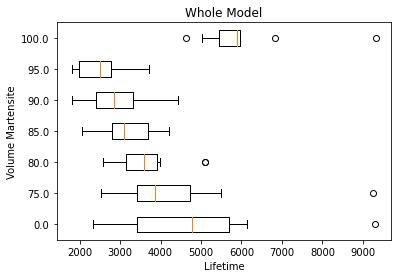

In [190]:
strain = 0.006
plt.boxplot(dic_df_whole_strains[strain]['LL_lifetime'], vert=False)
plt.yticks([num +1 for num in range(len(dic_df_whole_strains[strain]['volumes']))], dic_df_whole_strains[strain]['volumes'])

plt.xlabel('Lifetime')
plt.ylabel('Volume Martensite')
plt.title('Whole Model')


tikzplotlib.save(os.path.join(ImageOrdner, 'Boxplot_Whole_strain06.tex'))
plt.savefig(os.path.join(ImageOrdner, 'Boxplot_Whole_strain06.png'), bbox_inches='tight', dpi=150, transparent=True)

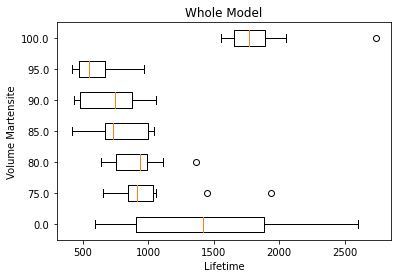

In [191]:
strain = 0.009

plt.boxplot(dic_df_whole_strains[strain]['LL_lifetime'], vert=False)
plt.yticks([num +1 for num in range(len(dic_df_whole_strains[strain]['volumes']))], dic_df_whole_strains[strain]['volumes'])

plt.xlabel('Lifetime')
plt.ylabel('Volume Martensite')
plt.title('Whole Model')


tikzplotlib.save(os.path.join(ImageOrdner, 'Boxplot_Whole_strain09.tex'))
plt.savefig(os.path.join(ImageOrdner, 'Boxplot_Whole_strain09.png'), bbox_inches='tight', dpi=150, transparent=True)

Boxplot für Ferritische Phase

In [192]:
dic_df_Ferrite_strains = {}
un_Ferrite_strains = np.unique(df_Ferrite['StrainAmplitude'].tolist())
for strains in un_Ferrite_strains:
    dic_df_Ferrite_strains[strains] = {'wholestrain': df_Ferrite[df_Ferrite['StrainAmplitude']==strains]}

In [193]:
volumes = []
for strains, dic in dic_df_Ferrite_strains.items():
    un_ferrite_vol = np.unique(df_Ferrite['Volume_Martensite'].tolist())
    df_bb = dic['wholestrain']
    for volumes in un_ferrite_vol:
        dic_df_Ferrite_strains[strains][volumes] = df_bb[df_bb['Volume_Martensite']==volumes]
    dic_df_Ferrite_strains[strains]['volumes'] = [kk for kk in un_ferrite_vol]
    

In [194]:
for strains, dic in dic_df_Ferrite_strains.items():
    ll_life = []
    dic_df_Ferrite_strains[strains]['LL_lifetime'] = ""
    for key, di in dic.items():
        if key in dic['volumes']:
            ll_life.append(di['Lifetime'].tolist())
    dic_df_Ferrite_strains[strains]['LL_lifetime'] = ll_life

del ll_life

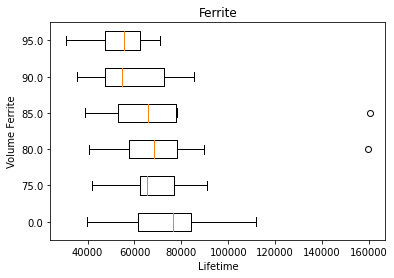

In [195]:
strain = 0.003
#dic_df_Ferrite_strains[strain]['volumes'] = [100 - kk for kk in dic_df_Ferrite_strains[strain]['volumes']]
plt.boxplot(dic_df_Ferrite_strains[strain]['LL_lifetime'], vert=False)

plt.yticks([num +1 for num in range(len(dic_df_Ferrite_strains[strain]['volumes']))], dic_df_Ferrite_strains[strain]['volumes'])

plt.xlabel('Lifetime')
plt.ylabel('Volume Martensite')
plt.title('Ferrite')


tikzplotlib.save(os.path.join(ImageOrdner, 'Boxplot_Ferrite_strain03.tex'))
plt.savefig(os.path.join(ImageOrdner, 'Boxplot_Ferrite_strain03.png'), bbox_inches='tight', dpi=150, transparent=True)

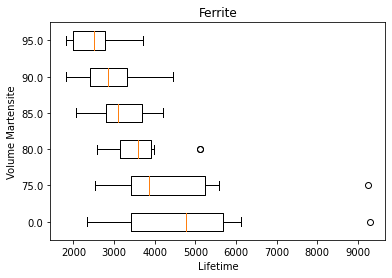

In [196]:
strain = 0.006
plt.boxplot(dic_df_Ferrite_strains[strain]['LL_lifetime'], vert=False)

plt.yticks([num +1 for num in range(len(dic_df_Ferrite_strains[strain]['volumes']))], dic_df_Ferrite_strains[strain]['volumes'])

plt.xlabel('Lifetime')
plt.ylabel('Volume Martensite')
plt.title('Ferrite')


tikzplotlib.save(os.path.join(ImageOrdner, 'Boxplot_Ferrite_strain06.tex'))
plt.savefig(os.path.join(ImageOrdner, 'Boxplot_Ferrite_strain06.png'), bbox_inches='tight', dpi=150, transparent=True)

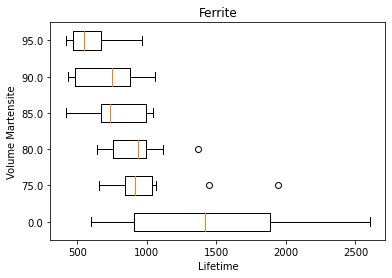

In [199]:
strain = 0.009
plt.boxplot(dic_df_Ferrite_strains[strain]['LL_lifetime'], vert=False)

plt.yticks([num +1 for num in range(len(dic_df_Ferrite_strains[strain]['volumes']))], dic_df_Ferrite_strains[strain]['volumes'])

plt.xlabel('Lifetime')
plt.ylabel('Volume Martensite')
plt.title('Ferrite')


tikzplotlib.save(os.path.join(ImageOrdner, 'Boxplot_Ferrite_strain09.tex'))
plt.savefig(os.path.join(ImageOrdner, 'Boxplot_Ferrite_strain09.png'), bbox_inches='tight', dpi=150, transparent=True)

Boxplot für Martensitische Phase

In [154]:
dic_df_Mart_strains = {}
un_Mart_strains = np.unique(df_mart['StrainAmplitude'].tolist())
for strains in un_Mart_strains:
    dic_df_Mart_strains[strains] = {'wholestrain': df_mart[df_mart['StrainAmplitude']==strains]}

In [155]:
volumes = []
for strains, dic in dic_df_Mart_strains.items():
    un_mart_vol = np.unique(df_mart['Volume_Martensite'].tolist())
    df_bb = dic['wholestrain']
    for volumes in un_mart_vol:
        dic_df_Mart_strains[strains][volumes] = df_bb[df_bb['Volume_Martensite']==volumes]
    dic_df_Mart_strains[strains]['volumes'] = list(un_mart_vol)
    

In [156]:
for strains, dic in dic_df_Mart_strains.items():
    ll_life = []
    dic_df_Mart_strains[strains]['LL_lifetime'] = ""
    for key, di in dic.items():
        if key in dic['volumes']:
            ll_life.append(di['Lifetime'].tolist())
    dic_df_Mart_strains[strains]['LL_lifetime'] = ll_life

del ll_life

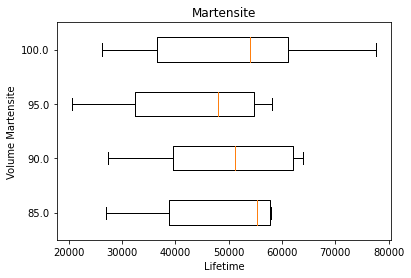

In [157]:
strain = 0.003
plt.boxplot(dic_df_Mart_strains[strain]['LL_lifetime'], sym="", vert=False)

plt.yticks([num +1 for num in range(len(dic_df_Mart_strains[strain]['volumes']))], dic_df_Mart_strains[strain]['volumes'])

plt.xlabel('Lifetime')
plt.ylabel('Volume Martensite')
plt.title('Martensite')


tikzplotlib.save(os.path.join(ImageOrdner, 'Boxplot_Mart_strain03.tex'))
plt.savefig(os.path.join(ImageOrdner, 'Boxplot_Mart_strain03.png'), bbox_inches='tight', dpi=150, transparent=True)

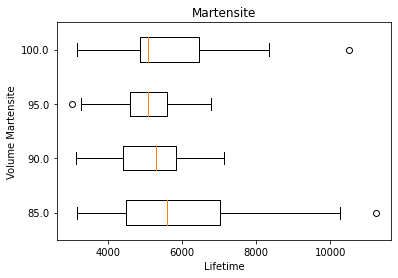

In [158]:
strain = 0.006
plt.boxplot(dic_df_Mart_strains[strain]['LL_lifetime'], vert=False)

plt.yticks([num +1 for num in range(len(dic_df_Mart_strains[strain]['volumes']))], dic_df_Mart_strains[strain]['volumes'])

plt.xlabel('Lifetime')
plt.ylabel('Volume Martensite')
plt.title('Martensite')


tikzplotlib.save(os.path.join(ImageOrdner, 'Boxplot_Mart_strain06.tex'))
plt.savefig(os.path.join(ImageOrdner, 'Boxplot_Mart_strain06.png'), bbox_inches='tight', dpi=150, transparent=True)

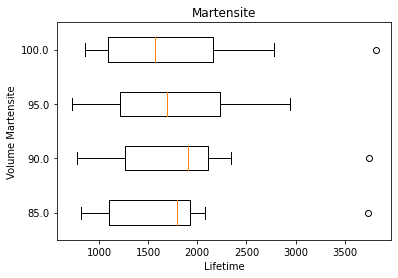

In [159]:
strain = 0.009
plt.boxplot(dic_df_Mart_strains[strain]['LL_lifetime'], vert=False)

plt.yticks([num +1 for num in range(len(dic_df_Mart_strains[strain]['volumes']))], dic_df_Mart_strains[strain]['volumes'])

plt.xlabel('Lifetime')
plt.ylabel('Volume Martensite')
plt.title('Martensite')


tikzplotlib.save(os.path.join(ImageOrdner, 'Boxplot_Mart_strain09.tex'))
plt.savefig(os.path.join(ImageOrdner, 'Boxplot_Mart_strain09.png'), bbox_inches='tight', dpi=150, transparent=True)